## understanding basics of langraph / chain


In [26]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
gpt40_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt_35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

In [9]:
from langchain_core.messages import HumanMessage
msg = HumanMessage(content="hey AI", name="Nitin")
messages = [msg]
gpt40_chat.invoke(messages)

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6e9E0BkOC1tGS4IHo035pugqis64', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--64c1e1df-7e0d-4f85-a3e1-e11e6b5409f9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [21]:
#building simple graph

from typing import TypedDict, Literal

class State(TypedDict):
    graph_state: str

def node_1(State):
    print("--Node1--")
    return {"graph_state": State["graph_state"]+ " I am"}

def node_2(State):
    print("--Node2--")
    return {"graph_state": State["graph_state"]+ " sad"}

def node_3(State):
    print("--Node3--")
    return {"graph_state": State["graph_state"]+ " Happy "}

#adding adges

import random
def decide_mood(State) -> Literal["node_2", "node_3"]:
    user_input = State['graph_state']
    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"




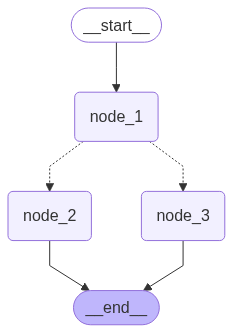

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
graph.invoke({"graph_state": "Hi, this is nitin."})

--Node1--
--Node2--


{'graph_state': 'Hi, this is nitin. I am sad'}

### React Agentic

In [39]:
#creating tols 
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int )-> int:
    '''multiplies '''
    return a*b

def add(a,b):
    '''Adds '''
    return a+b

def divide(a,b):
    '''Divide the numbers'''
    return a/b

In [40]:
tools = [multiply, add, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [45]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage

sys_msg = SystemMessage(content= "You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#node
def assistant(state: MessagesState):
    
    return {"messages": [llm_with_tools.invoke([sys_msg] + state['messages'])]}

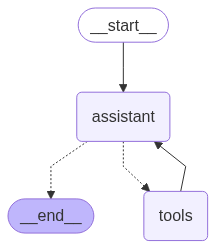

In [47]:
#building graph
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node('assistant', assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition,
)
builder.add_edge('tools', "assistant")
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [48]:
messages = [ HumanMessage(content="Add 5 and 6. Multiply the out put by 3 and divide by 5")]
messages = react_graph.invoke({"messages": messages})

In [50]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 6. Multiply the out put by 3 and divide by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_FxKrZdkG544VxwpXvrJvK11r)
 Call ID: call_FxKrZdkG544VxwpXvrJvK11r
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YoXOtXtSsdBiVqhx38UDQFXE)
 Call ID: call_YoXOtXtSsdBiVqhx38UDQFXE
  Args:
    a: 11
    b: 3
  divide (call_ylR3jsHkQPUpQL4NFbhcAv3T)
 Call ID: call_ylR3jsHkQPUpQL4NFbhcAv3T
  Args:
    a: 33
    b: 5
================================= Tool Message =================================
Name: multiply

33
================================= Tool Message =================================
Name: divide

6.6
================================== Ai Message ===============